In [249]:
import pandas as pd
import nltk
import re
import numpy as np
import heapq
from nltk.corpus import stopwords
import PyPDF2
import pdfplumber
from sklearn.metrics import f1_score
import os
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

## PDF to TXT

In [110]:
apple_file = ['apple_reports/text_files/Apple_report_2020-10-30.txt',
              'apple_reports/text_files/Apple_report_2021-01-28.txt',
              'apple_reports/text_files/Apple_report_2021-04-29.txt',
              'apple_reports/text_files/Apple_report_2021-06-11.txt',
              'apple_reports/text_files/Apple_report_2021-07-28.txt',
              'apple_reports/text_files/Apple_report_2021-09-15.txt',
              'apple_reports/text_files/Apple_report_2021-10-19.txt',
              'apple_reports/text_files/Apple_report_2021-10-29.txt']

In [126]:
## Convert pdf to txt Pipeline
def pdf_to_txt(filepath):
    pdffileobj = open(filepath,'rb')
    pdfreader = PyPDF2.PdfFileReader(pdffileobj)
    x = pdfreader.numPages

    pdf = pdfplumber.open(filepath)
    text_string = ""
    for i in range(x):
        page = pdf.pages[i]
        text = page.extract_text()
        text_string += text
    pdf.close()
    
    
    new_file_name = 'apple_reports/text_files/Apple_report_{}.txt'.format(filepath[27:37])
    with open(new_file_name, 'w') as f:
        f.write(text_string)

### convert more news

In [11]:
## Convert pdf to txt for news
def pdf_to_txt_news(filepath):
    pdffileobj = open('apple_news/' + filepath,'rb')
    pdfreader = PyPDF2.PdfFileReader(pdffileobj)
    x = pdfreader.numPages

    pdf = pdfplumber.open('apple_news/' + filepath)
    text_string = ""
    for i in range(x):
        page = pdf.pages[i]
        text = page.extract_text()
        text_string += text
    pdf.close()
    
    
    new_file_name = 'apple_news/text_files/{}.txt'.format(filepath[:-4])
    with open(new_file_name, 'w') as f:
        f.write(text_string)

In [13]:
for filename in os.listdir("apple_news/"):
    if filename.endswith(".pdf"): 
        pdf_to_txt_news(filename)

### get dates

In [34]:
f = open("apple_news/text_files/Apple announces first states signed up to adopt driver’s licenses and state IDs in Apple Wallet.txt", "r")
article = f.read()

In [74]:
def get_dates(filepath, year):
    f = open("apple_news/text_files/" + filepath, "r")
    article = f.read()
    
    ind_2021 = int(article.index(year))
    month = article[ind_2021-16:ind_2021+4]
    if 'January' in month:
        m = '01'
    elif 'February' in month:
        m = '02'
    elif 'March' in month:
        m = '03'
    elif 'April' in month:
        m = '04'
    elif 'May' in month:
        m = '05'
    elif 'June' in month:
        m = '06'
    elif 'July' in month:
        m = '07'
    elif 'August' in month:
        m = '08'
    elif 'September' in month:
        m = '09'
    elif 'October' in month:
        m = '10'
    elif 'November' in month:
        m = '11'
    elif 'December' in month:
        m = '12'
    else:
        m = 'None'

    day = article[ind_2021-4:ind_2021-2]
    if day[0] == " ":
        d = '0' + day[1]
    else:
        d = day

    return filepath, year + '-' + m + '-' + d

In [77]:
df_dates = pd.DataFrame(columns=['name', 'date'])
for filename in os.listdir("apple_news/text_files/"):
    if filename.endswith(".txt"): 
        file, date = get_dates(filename, "2021")
        d = {'name':file, 'date':date}
        df_dates = df_dates.append(d, ignore_index=True)

In [82]:
df_dates.iloc[7, 1] = "2021-09-20"
df_dates.iloc[8, 1] = "2021-10-04"

In [90]:
df_dates['date'].unique()

array(['2021-08-30', '2021-08-26', '2021-08-17', '2021-09-28',
       '2021-09-01', '2021-09-14', '2021-09-20', '2021-10-04',
       '2021-10-05', '2021-06-22'], dtype=object)

## Positive and Negative word lists

In [91]:
df_pos = pd.read_csv('LoughranMcDonald_Positive.csv', header=None)
df_pos = df_pos.drop(1, axis=1)
df_pos.columns = ['positive_words']
df_pos['positive_words'] = df_pos['positive_words'].apply(lambda x: x.lower())
df_pos

,positive_words
0,able
1,abundance
2,abundant
3,acclaimed
4,accomplish
...,...
349,win
350,winner
351,winners
352,winning


In [92]:
df_neg = pd.read_csv('LoughranMcDonald_Negative.csv', header=None)
df_neg = df_neg.drop(1, axis=1)
df_neg.columns = ['negative_words']
df_neg['negative_words'] = df_neg['negative_words'].apply(lambda x: x.lower())
df_neg

,negative_words
0,abandon
1,abandoned
2,abandoning
3,abandonment
4,abandonments
...,...
2345,wrongdoing
2346,wrongdoings
2347,wrongful
2348,wrongfully


In [93]:
pos_words_list = list(df_pos['positive_words'])
neg_words_list = list(df_neg['negative_words'])

## AutoPhrase

In [94]:
df = pd.read_fwf('models/DBLP/AutoPhrase_multi-words.txt', header=None)
df.columns = ['score', 'phrase']
df

,score,phrase
0,0.985933,riemannian manifolds
1,0.985446,cerebral aneurysms
2,0.985365,mars rover
3,0.985282,extractive summarization
4,0.984483,minkowski sums
...,...,...
653781,0.008033,also developed to
653782,0.007991,and then used in
653783,0.007915,not known in
653784,0.007630,a number of algorithms for


In [95]:
def add_coefficient(word):
    word_list = word.split(" ")
    if any(i in pos_words_list for i in word_list):
        return 1
    elif any(i in neg_words_list for i in word_list):
        return -1
    else:
        return 0

In [96]:
df['coefficient'] = df['phrase'].apply(add_coefficient)
df

,score,phrase,coefficient
0,0.985933,riemannian manifolds,0
1,0.985446,cerebral aneurysms,0
2,0.985365,mars rover,0
3,0.985282,extractive summarization,0
4,0.984483,minkowski sums,0
...,...,...,...
653781,0.008033,also developed to,0
653782,0.007991,and then used in,0
653783,0.007915,not known in,0
653784,0.007630,a number of algorithms for,0


In [97]:
df['weighted_score'] = df['score'] * df['coefficient']
df

,score,phrase,coefficient,weighted_score
0,0.985933,riemannian manifolds,0,0.000000
1,0.985446,cerebral aneurysms,0,0.000000
2,0.985365,mars rover,0,0.000000
3,0.985282,extractive summarization,0,0.000000
4,0.984483,minkowski sums,0,0.000000
...,...,...,...,...
653781,0.008033,also developed to,0,0.000000
653782,0.007991,and then used in,0,0.000000
653783,0.007915,not known in,0,0.000000
653784,0.007630,a number of algorithms for,0,0.000000


In [119]:
aapl_stock = pd.read_csv('apple_stock/AAPL_labels.csv')
aapl_stock_2 = pd.read_csv('apple_stock/AAPL_labels_1.csv')
aapl_stock_2 = pd.concat([aapl_stock, aapl_stock_2.iloc[:, 1:]], 1)
aapl_stock_2

,Unnamed: 0,2020-10-30,2021-01-28,2021-04-29,2021-06-11,2021-07-28,2021-09-15,2021-10-19,2021-10-29,2021-06-22,2021-08-17,2021-08-26,2021-08-30,2021-09-01,2021-09-14,2021-09-20,2021-09-28,2021-10-04,2021-10-05
0,Initial Price,108.00666809082033,136.25003051757812,132.8603973388672,126.9741668701172,144.55213928222656,148.81280517578125,148.54319763183594,149.58169555664062,133.5845947265625,149.97113037109375,147.32498168945312,152.8968505859375,152.28773498535156,147.9041290283203,142.731689453125,141.70318603515625,138.93722534179688,140.90435791015625
1,7 days,113.0306167602539,134.3821803501674,129.90862492152624,129.92543247767858,145.76426478794642,145.91988917759485,148.7828587123326,150.26503426688058,134.2127467564174,148.2308066231864,151.42899431501115,153.66287667410714,153.39041791643416,146.1039036342076,144.53904942103796,141.3850838797433,141.61617388044084,141.86866324288505
2,7 days label,True,False,False,True,True,False,True,True,True,False,True,True,True,False,True,False,True,True
3,14 days,115.55491365705218,134.2241930280413,127.55971963065011,132.06908961704798,146.54605102539062,144.30724443708147,149.6602074759347,150.20966012137276,138.08699471609933,149.82990046909876,151.42828151157923,151.33627101353235,150.01106153215682,144.94773755754744,143.06049455915178,142.01844460623605,143.8129664829799,144.49411555698939
4,14 days label,True,False,False,True,True,False,True,True,True,False,True,False,False,False,True,True,True,True
5,30 days,117.6401735941569,128.1640416463216,126.42386271158854,138.59410909016927,148.6869644165039,144.69149424235027,152.73009745279947,158.13450826009114,142.347998046875,148.79350738525392,147.24210510253906,146.8949447631836,146.1450393676758,144.65155181884765,144.93580576578776,146.0092519124349,146.96022033691406,147.3289794921875
6,30 days label,True,False,False,True,True,False,True,True,True,False,False,False,False,False,True,True,True,True
7,90 days,125.58221647474501,127.2166118197971,137.7187739054362,144.01168721516927,149.09749247233074,153.36501200058882,158.657338922674,160.75264570448132,145.47837592230903,152.70022270896217,153.0864685435354,153.21893059452879,153.24402509416853,153.28586876910666,153.62442650428184,154.50029767569848,155.40830216841263,155.71332210964627
8,90 days label,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [99]:
aapl_stock.iloc[2,1:]

2020-10-30     True
2021-01-28    False
2021-04-29    False
2021-06-11     True
2021-07-28     True
2021-09-15    False
2021-10-19     True
2021-10-29     True
Name: 2, dtype: object

## Bag of Words

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhumingjia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
dataset = nltk.sent_tokenize(text_string)
for i in range(len(dataset)):
    dataset[i] = dataset[i].lower()
    dataset[i] = re.sub(r'\W', ' ', dataset[i])
    dataset[i] = re.sub(r'\s+', ' ', dataset[i])
    dataset[i] = dataset[i].split()
    dataset[i] = [word for word in dataset[i] if not word in set(stopwords.words('english'))]
    dataset[i] = ' '.join(dataset[i])
    dataset[i] = ''.join([j for j in dataset[i] if not j.isdigit()])

In [32]:
word2count = {}
for data in dataset:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1

In [55]:
freq_words = heapq.nlargest(5000, word2count, key=word2count.get)

In [64]:
count_pos = 0
for i in freq_words:
    if i in pos_list:
        count_pos += 1
        
count_neg = 0
for i in freq_words:
    if i in neg_list:
        count_neg += 1
        
if count_pos > count_neg:
    print("True")
else:
    print("False")

False


## Bag of Words Pipeline

In [244]:
dates_df = pd.read_csv('apple_news/text_files/dates.csv', index_col=0)
dates_df

,name,date
0,Apple acquires classical music streaming servi...,2021-08-30
1,Apple introduces the News Partner Program.txt,2021-08-26
2,"Apple, US Developers Agree to App Store Update...",2021-08-26
3,Apple Selects 15 Black- and Brown-Owned Busine...,2021-08-17
4,"New Features in Keynote, Pages, and Numbers En...",2021-09-28
5,Apple announces first states signed up to adop...,2021-09-01
6,Apple Unveils iPhone 13 Pro and iPhone 13 Pro ...,2021-09-14
7,Apple’s global hit comedy series _Ted Lasso_ s...,2021-09-20
8,BetterInvesting™ Magazine Selects Apple as _Gr...,2021-10-04
9,Hagens Berman_ U.S. iOS Developers to Benefit ...,2021-08-26


In [245]:
def bag_of_words_prediction(filepath, n):
#     pdffileobj = open(filepath,'rb')
#     pdfreader = PyPDF2.PdfFileReader(pdffileobj)
#     x = pdfreader.numPages

#     pdf = pdfplumber.open(filepath)
#     text_string = ""
#     for i in range(x):
#         page = pdf.pages[i]
#         text = page.extract_text()
#         text_string += text
#     pdf.close()

    f = open(filepath)
    text_string = f.read()
    
    dataset = nltk.sent_tokenize(text_string)
    for i in range(len(dataset)):
        dataset[i] = dataset[i].lower()
        dataset[i] = re.sub(r'\W', ' ', dataset[i])
        dataset[i] = re.sub(r'\s+', ' ', dataset[i])
        dataset[i] = dataset[i].split()
        dataset[i] = [word for word in dataset[i] if not word in set(stopwords.words('english'))]
        dataset[i] = ' '.join(dataset[i])
        dataset[i] = ''.join([j for j in dataset[i] if not j.isdigit()])
        
    word2count = {}
    for data in dataset:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count.keys():
                word2count[word] = 1
            else:
                word2count[word] += 1
                
    freq_words = heapq.nlargest(n, word2count, key=word2count.get)
    count_pos = 0
    for i in freq_words:
        if i in pos_words_list:
            count_pos += word2count[i]

    count_neg = 0
    for i in freq_words:
        if i in neg_words_list:
            count_neg += word2count[i]

    if count_pos > count_neg:
        return 1
    else:
        return 0

In [248]:
for n in [500, 1000, 2000, 3000, 4000, 5000]:
    for m in [2, 4, 6]:
        preds = []
        for i in apple_file:
            preds.append(bag_of_words_prediction(i, n))

        aapl_label = []
        for i in list(aapl_stock.iloc[m,1:]):
            if i == 'True':
                aapl_label.append(1)
            else:
                aapl_label.append(0)

        for filename in os.listdir("apple_news/text_files/"):
            if filename.endswith(".txt"): 
                preds.append(bag_of_words_prediction("apple_news/text_files/" + filename, n))
                date_time = dates_df[dates_df['name'] == filename].date.values[0]
                label = aapl_stock_2[date_time].iloc[m]
                if label == 'True':
                    aapl_label.append(1)
                else:
                    aapl_label.append(0)

        f1 = f1_score(preds, aapl_label)
        print(str(n) + ' ' + str(m) + ": " + str(f1))

500 2: 0.5454545454545454
500 4: 0.5
500 6: 0.41379310344827586
1000 2: 0.5625000000000001
1000 4: 0.5161290322580646
1000 6: 0.42857142857142855
2000 2: 0.5806451612903226
2000 4: 0.5333333333333333
2000 6: 0.4444444444444445
3000 2: 0.5806451612903226
3000 4: 0.5333333333333333
3000 6: 0.4444444444444445
4000 2: 0.5806451612903226
4000 4: 0.5333333333333333
4000 6: 0.4444444444444445
5000 2: 0.5806451612903226
5000 4: 0.5333333333333333
5000 6: 0.4444444444444445


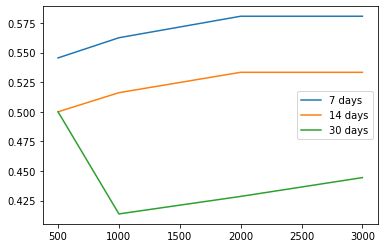

In [252]:
plt.plot([500, 1000, 2000, 3000], [0.5454545, 0.5625, 0.580645, 0.58064516], label='7 days')
plt.plot([500, 1000, 2000, 3000], [0.5, 0.516129, 0.53333333, 0.533333333], label='14 days')
plt.plot([500, 1000, 2000, 3000], [0.5, 0.4137931, 0.4285714, 0.44444444], label='30 days')
plt.legend()

In [186]:
preds

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

In [187]:
aapl_label

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

7 days: 0.5806451612903226
14 days: 0.5333333333333333
30 days: 0.4444444444444445

## TF-IDF Pipeline

In [190]:
article

'2/1/22, 9:16 AM Apple announces ﬁrst states signed up to adopt driver’s licenses and state IDs in Apple Wallet\nQuote Lookup\nApAplep Incp. (AlAeP La) nnounces ﬁrst states signed\nAdd to watchlist Visitors trend 2W 10W 9M\nNasdaqGS - NasdaqGS Real Time Price. Currency in USD Related Quotes\n1u70p. 3to3 adopt driver’s licenses and SymbQoluote LookupLast Price Change % Change\n+11.11 (+6.98%) 170.70 +0.37 (+0.22%)\n       \nAAPL 173.79 -0.99 -0.57%\nAt csloset: Jaanuatry e28 0 4I:00DPM EsST in AppleAft eWr hoursa: Janl 2l8,e 07:t59PM EST Apple Inc.\nSummary Company Outlook Chart Conversations Statistics Historical Data Proﬁle Financials Analysis Options Holders Sustainability\nRecently Viewed\nSymbol Last Price Change % Change\nSeptember 1, 2021\nAAPL 173.79 -0.99 -0.57%\nApple Inc.\nIn this article:\nAAPL\n-0.57%\nArizona, Connecticut, Georgia, Iowa, Kentucky,\nMaryland, Oklahoma, and Utah are among the ﬁrst\nstates to bring state IDs and driver’s licenses in\nTeen who turned down $5,0

In [191]:
sentence_list = article.split("\n")

sentences = []
word_set = []
 
for sent in sentence_list:
    x = [i.lower() for  i in word_tokenize(sent) if i.isalpha()]
    sentences.append(x)
    for word in x:
        if word not in word_set:
            word_set.append(word)


word_set = set(word_set)

total_documents = len(sentences)
 
#Creating an index for each word in our vocab.
index_dict = {} #Dictionary to store index for each word
i = 0
for word in word_set:
    index_dict[word] = i
    i += 1

In [192]:
def count_dict(sentences):
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in sentences:
            if word in sent:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(sentences)

In [193]:
def termfreq(document, word):
    N = len(document)
    occurance = len([token for token in document if token == word])
    return occurance/N

In [194]:
def inverse_doc_freq(word):
    try:
        word_occurance = word_count[word] + 1
    except:
        word_occurance = 1
    return np.log(total_documents/word_occurance)

In [195]:
def tf_idf(sentence):
    tf_idf_vec = np.zeros((len(word_set),))
    for word in sentence:
        tf = termfreq(sentence,word)
        idf = inverse_doc_freq(word)
         
        value = tf*idf
        tf_idf_vec[index_dict[word]] = value 
    return tf_idf_vec

In [198]:
vectors = []
for sent in sentences:
    vec = tf_idf(sent)
    vectors.append(vec)
 
len(vectors)

110

In [199]:
len(sentence_list)

110

In [201]:
len(word_set)

349

In [203]:
dataset = article.split("\n")

for i in range(len(dataset)):
    dataset[i] = dataset[i].lower()
    dataset[i] = re.sub(r'\W', ' ', dataset[i])
    dataset[i] = re.sub(r'\s+', ' ', dataset[i])
    dataset[i] = dataset[i].split()
    dataset[i] = [word for word in dataset[i] if not word in set(stopwords.words('english'))]
    dataset[i] = ' '.join(dataset[i])
    dataset[i] = ''.join([j for j in dataset[i] if not j.isdigit()])

In [217]:
count = CountVectorizer()
word_count = count.fit_transform(dataset)

In [223]:
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])

In [224]:
df_idf

,idf_weights
aapl,4.323236
ability,5.016383
according,5.016383
account,5.016383
across,4.610918
...,...
yahoo,3.070473
yellowheart,5.016383
ﬁnance,3.917771
ﬁrst,3.311635


In [225]:
tf_idf_vector = tfidf_transformer.transform(word_count)
feature_names = count.get_feature_names()

In [226]:
first_document_vector = tf_idf_vector[1]
df_tfifd = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])

In [227]:
df_tfifd.sort_values(by=["tfidf"],ascending=False)

,tfidf
quote,0.707107
lookup,0.707107
aapl,0.000000
races,0.000000
residents,0.000000
...,...
fuel,0.000000
forefront,0.000000
fool,0.000000
follow,0.000000


In [210]:
df_tfifd[df_tfifd['tfidf'] != 0]

,tfidf
lookup,0.707107
quote,0.707107
